# MMMI Oversight Script


In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import sys

sys.path.append('.')

import hark_portfolio_agents as hpa

In [3]:
sys.path.append('../PNL/py')

import util as UTIL
import pnl as pnl

## Initialize the Simulation

### Initialize market information

Some initial values for the simulation.

$RAP_0$ is the starting risky asset price. This is adjust after every trading day.

In [4]:
risky_asset_price = 100

HARK uses numerical values for wealth. This variable converts "HARK money" to dollars.

In [5]:
dollars_per_hark_money_unit = 1000

Expected rate of return and standard deviation of the market price process will be updated over time.

These are the starting values, derived from the S&P 500.

$\bar{r}_0 = 0.000628$

$sr_0 = 0.011988$

In [6]:
sp500_ror = 0.000628
sp500_std = 0.011988

market_rate_of_return = sp500_ror
market_standard_deviation = sp500_std

Calendar variables. Will ultimately set to be realistic; for now set low for testing.

In [7]:
days_per_quarter = 10
quarters_per_simulation = 6

An attention rate: the chance on any day that an agent will pay attention to the market and trade.

Later, this can be a more realistic function of agent circumstances.

In [8]:
attention_rate = 1 / days_per_quarter

We will need to convert daily price statistics to quarterly price statistics. HARK agents use quarterly (?) statistics. [**Question**: Should HARK agents rebalance knowing how many days are left in the quarter? Or based on a mean number of days between rebalancing periods (based on the attention rate)?]

In [9]:
import math

def ror_quarterly(ror, n_q):
    return pow(1 + ror, n_q) - 1

def sig_quarterly(std, n_q):
    """
     The second formula only holds for special cases (see the attached paper by Andrew Lo), 
     but since we are generating the data we meet this special case.
    """
    return math.sqrt(n_q) * std

### Initialize agents to start

This is to set up the agent parameters and quantities used in the simulation.

`CRRA` refers to the `\rho` parameter in the constant relative risk aversion utility function used by the agents. Utility is over units of resources consumed.

`aNrmInitStd` is normalized initial market assets, standard deviation. The agents' starting wealth is drawn from a lognormal distribution with this standard deviation.

`pLvlInitMean` and `pLvlInitStd` are the mean and standard deviation of the initial level of permanent income of the agents.

In [10]:
## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    {
        'CRRA': .9,
        'AgentCount' : 10,
        'aNrmInitMean' : 10
    }] * 10 + \
    [{
        'CRRA': .95, 
        'AgentCount' : 10,
        'aNrmInitMean': 10
    }] * 10 + \
    [{
        'CRRA': .99, 
        'AgentCount' : 10,
        'aNrmInitMean' : 10
    }] * 10


### parameters shared by all agents
agent_parameters = {
    'aNrmInitStd' : 0.0,
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0,
    'Rfree' : 0,
    'RiskyAvg': market_rate_of_return,
    'RiskyStd': market_standard_deviation,    
}

In [11]:
len(agent_classes)

30

Initialize the agents.

In [12]:
agents = hpa.create_agents(agent_classes, agent_parameters)

In [13]:
agents[0].state_now

{'pLvl': array([2.33482594, 2.73191849, 2.33482594, 2.95954583, 3.20232689,
        2.63313315, 2.83445475, 2.63313315, 3.20232689, 2.83445475]),
 'PlvlAgg': 1.0,
 'bNrm': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'mNrm': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'aNrm': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'aLvl': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

## Get agent risky allocations

Use this stock price to determine the initial number of shares of the risky asset held by each
agent:
 - $RAS_{i0} = (HEC_{i0}.RAW)/ RAP_0$
 
 where RAW is Risky Asset Wealth, amount of resources allocated to the risky asset.
 
 RAS is Risky Asset Shares, number of shares the agent has.

In [14]:
def compute_share_demand(agent):
    agent.solve()
    market_resources = agent.state_now['mNrm']
    permanent_income = agent.state_now['pLvl']
    
    print("Market Resources: " + str(market_resources))

    # ShareFunc takes normalized market resources as argument
    risky_share = agent.solution[0].ShareFuncAdj(
        market_resources
    )
    
    # denormalize the risky share. See https://github.com/econ-ark/HARK/issues/986
    risky_asset_wealth = risky_share \
                        * market_resources \
                        * permanent_income \
                        * dollars_per_hark_money_unit 
    
    print("Risky Share: " + str(risky_share))
    print("Risky Asset Wealth: " + str(risky_asset_wealth))
    
    shares = risky_asset_wealth / risky_asset_price
    
    print("Shares: " + str(shares))
    
    return shares

In [15]:
for agent in agents:
    agent.shares = compute_share_demand(agent)

Market Resources: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2334.82593888 2731.91848655 2334.82593888 2959.54583051 3202.32688908
 2633.13315336 2834.45474991 2633.13315336 3202.32688908 2834.45474991]
Shares: [23.34825939 27.31918487 23.34825939 29.59545831 32.02326889 26.33133153
 28.3445475  26.33133153 32.02326889 28.3445475 ]
Market Resources: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2334.82593888 2731.91848655 2334.82593888 2959.54583051 3202.32688908
 2633.13315336 2834.45474991 2633.13315336 3202.32688908 2834.45474991]
Shares: [23.34825939 27.31918487 23.34825939 29.59545831 32.02326889 26.33133153
 28.3445475  26.33133153 32.02326889 28.3445475 ]
Market Resources: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2334.82593888 2731.91848655 2334.82593888 2959.54583051 3202.32688908
 2633.13315336 2834.45474991 2633.13

Market Resources: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2334.82593888 2731.91848655 2334.82593888 2959.54583051 3202.32688908
 2633.13315336 2834.45474991 2633.13315336 3202.32688908 2834.45474991]
Shares: [23.34825939 27.31918487 23.34825939 29.59545831 32.02326889 26.33133153
 28.3445475  26.33133153 32.02326889 28.3445475 ]
Market Resources: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2334.82593888 2731.91848655 2334.82593888 2959.54583051 3202.32688908
 2633.13315336 2834.45474991 2633.13315336 3202.32688908 2834.45474991]
Shares: [23.34825939 27.31918487 23.34825939 29.59545831 32.02326889 26.33133153
 28.3445475  26.33133153 32.02326889 28.3445475 ]
Market Resources: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2334.82593888 2731.91848655 2334.82593888 2959.54583051 3202.32688908
 2633.13315336 2834.45474991 2633.13

## Prepare the main loop

Functions to automate aspects of the main loop.
(Will move this to module code once finalized).

### Data stores

For prices, rates or return, and standard deviations over time.


In [16]:

prices = []
ror_list = []
std_list = []

expected_ror_list = []
expected_std_list = []

buy_sell_list = []

### Activating agents

"At the beginning of each trading day $t + 1$, select a random group of HARK agents with replacement."

**TODO**: HARK AgentType classes represent multiple agents (as many as `AgentCount`). It is difficult to have the agents within the same AgentType act 'separately', though these agents will have _ex ante_ and _ex post_ heterogeneity of some variables. For the purpose of MMMI, we may need to scaffold the agent model to make it easier to have multiple independently acting agents.

In [17]:
import random

def activate(agents, attention_rate):
    for agent in agents:
        agent.attentive = random.random() < attention_rate

In [18]:
activate(agents, attention_rate)

"**First**, determine the expected return and standard deviation of the risky asset to be used for decision period $t + 1$."

A number of constants used in the calculation of risky expecations.

In [19]:
import math

p1 = 0.1
delta_t1 = 30

a = - math.log(p1) / delta_t1

p2 = 0.1
delta_t2 = 60

b = math.log(p2) / delta_t2

In [20]:
def calculate_risky_expectations():
    # note use of data store lists for time tracking here -- not ideal
    D_t = sum([math.exp(a * l) for l in ror_list])
    S_t = math.exp(b * len(prices))
    
    w_0 = S_t
    w_t = [(1 - S_t) * math.exp(a * (t+1)) / D_t for t in range(len(ror_list))]
    
    expected_ror = w_0 * sp500_ror + sum(
        [w_ror[0] * w_ror[1]
         for w_ror
         in zip(w_t, ror_list)])
    expected_ror_list.append(expected_ror)
    
    expected_std = math.sqrt(
        w_0 * pow(sp500_std, 2) \
        +  sum([w_ror_er[0] * pow(w_ror_er[1] - w_ror_er[2], 2)
                for w_ror_er
                in zip(w_t, ror_list, expected_ror_list)]))
    expected_std_list.append(expected_std)

    # TODO: This should be an adaptive function of market prices
    # as described in John's Experiment design.
    # This is a stopgap for now.
    market_risky_params = {
        'RiskyAvg': ror_quarterly(expected_ror, days_per_quarter),
        'RiskyStd': sig_quarterly(expected_std, days_per_quarter)
    }
    
    return market_risky_params


"**Second**, using [these expectations] calculate the total number of shares of the risky asset that the selected agents want to buy and sell."

In [21]:
def compute_total_buy_sell(agents):
    """
    TODO: Should this be done without making so many changes to the underlying
    agent? Could be done using copies.
    """
    risky_expectations = calculate_risky_expectations()
    
    buy_shares_total = 0
    sell_shares_total = 0
    
    for agent in agents:
        if agent.attentive:
            # Note: this mutates the underlying agent
            agent.assign_parameters(**risky_expectations)
            
            d_shares = compute_share_demand(agent)
            
            delta_shares = d_shares - agent.shares
            
            # NOTE: This mutates the agent
            agent.shares = d_shares
            
            buy_shares_total += delta_shares[delta_shares > 0].sum()
            sell_shares_total += -delta_shares[delta_shares < 0].sum()
            
    return (round(buy_shares_total), round(sell_shares_total))

In [22]:
compute_total_buy_sell(agents)

Market Resources: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2334.82593888 2731.91848655 2334.82593888 2959.54583051 3202.32688908
 2633.13315336 2834.45474991 2633.13315336 3202.32688908 2834.45474991]
Shares: [23.34825939 27.31918487 23.34825939 29.59545831 32.02326889 26.33133153
 28.3445475  26.33133153 32.02326889 28.3445475 ]
Market Resources: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2334.82593888 2731.91848655 2334.82593888 2959.54583051 3202.32688908
 2633.13315336 2834.45474991 2633.13315336 3202.32688908 2834.45474991]
Shares: [23.34825939 27.31918487 23.34825939 29.59545831 32.02326889 26.33133153
 28.3445475  26.33133153 32.02326889 28.3445475 ]
Market Resources: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2334.82593888 2731.91848655 2334.82593888 2959.54583051 3202.32688908
 2633.13315336 2834.45474991 2633.13

(0, 0)

"**Third**, using [total buy and sell shares] as input to the Buy Broker and Sell Broker, run a day of NetLogo trading and determine the end of day price of the risky asset."

In [23]:
import os

def run_market(config, buy_sell, seed = None):    
    pnl.run_NLsims(
        config,
        broker_buy_limit = buy_sell[0],
        broker_sell_limit = buy_sell[1],
        SEED = seed,
        use_cache = True
    )

"**Fourth**, use the final price to calculate the amount of wealth each (all) HARK agent has allocated to the risky asset."

In [24]:
def get_transactions(config, seed = 0, buy_sell = (0,0)):
    logfile = pnl.transaction_file_name(config, seed, buy_sell[0], buy_sell[1])
    
    # use run_market() first to create logs
    transactions = pd.read_csv(
        logfile,
        delimiter='\t'
    )
    return transactions

def get_last_simulation_price(config, seed = 0, buy_sell = (0,0)):
    """
    Dividing the output of this by 4
    """
    
    transactions = get_transactions(config, seed=seed, buy_sell = buy_sell)
    prices = transactions['TrdPrice']
    
    return prices[prices.index.values[-1]]

In [25]:
netlogo_ror = -0.00052125
netlogo_std =  0.0068
simulation_price_scale = 0.25

def daily_rate_of_return(config = None, seed = 0, buy_sell = (0, 0)):
    
    last_sim_price = get_last_simulation_price(config, seed=seed, buy_sell = buy_sell)
    
    ror = (last_sim_price * simulation_price_scale - 100) / 100
    
    # adjust to calibrated NetLogo to S&P500
    ror = sp500_std * (ror - netlogo_ror) / netlogo_std + sp500_ror
    
    return ror

In [26]:
def update_agent_wealth(old_share_price, ror):

    new_share_price = old_share_price * (1 + ror)

    for agent in agents:
        market_resources = agent.state_now['mNrm'] * agent.state_now['pLvl']
    
        old_raw = agent.shares * old_share_price
        new_raw = agent.shares * new_share_price
    
        delta_mNrm = (new_raw - old_raw) / \
            (dollars_per_hark_money_unit * agent.state_now['pLvl'])
    
        agent.state_now['mNrm'] = agent.state_now['mNrm'] + delta_mNrm

"Repeat each trading day until the end of the quarter. Then update the economic conditions for each HARK agent (e.g., permanent income level), and repeat [daily loop]."

## Run the main loop



In [27]:
import itertools

seeds = itertools.cycle([0,1,2,3,4])

config = UTIL.read_config(
    config_file = "../PNL/macroliquidity.ini",
    config_local_file = "../PNL/macroliquidity_local.ini"
)

# Main loop
for quarter in range(quarters_per_simulation):
    print(f"Q-{quarter}")
    for agent in agents:
        agent.simulate(sim_periods=1)
    
    for day in range(days_per_quarter):
        print(f"Q-{quarter}:D-{day}")
        
        # Set to a number for a fixed seed, or None to rotate
        seed = next(seeds)

        prices.append(risky_asset_price)
        
        activate(agents, attention_rate)
        buy_sell = compute_total_buy_sell(agents)
        print("Buy/Sell Limit: " + str(buy_sell))
        buy_sell_list.append(buy_sell)
        
        run_market(config, buy_sell, seed = seed)
        
        ror =  daily_rate_of_return(config = config, seed = seed, buy_sell = buy_sell)
        print("ror: " + str(ror))
        ror_list.append(ror)
        
        update_agent_wealth(risky_asset_price, ror)
        
        risky_asset_price = risky_asset_price * (1 + ror)

config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini
Q-0
Q-0:D-0
Market Resources: [0.99441941 0.8817618  1.20937902 0.8817618  0.3        0.3
 1.20937902 0.8817618  1.11769122 1.20937902]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2333.44385247 2622.70596362 2944.36730995 2527.8697217   930.60473104
  860.05190819 3180.46584433 2249.06723963 4216.56385266 3445.12682993]
Shares: [23.33443852 26.22705964 29.4436731  25.27869722  9.30604731  8.60051908
 31.80465844 22.4906724  42.16563853 34.4512683 ]


Sim ID (SEED): 0


Market Resources: [0.99441941 0.8817618  1.20937902 0.8817618  0.3        0.3
 1.20937902 0.8817618  1.11769122 1.20937902]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2333.44385247 2622.70596362 2944.36730995 2527.8697217   930.60473104
  860.05190819 3180.46584433 2249.06723963 4216.56385266 3445.12682993]
Shares: [23.33443852 26.22705964 29.4436731  25.27869722  9.30604731  8.60051908
 31.80465844 22.4906724  42.16563853 34.4512683 ]
Market Resources: [0.99441941 0.8817618  1.20937902 0.8817618  0.3        0.3
 1.20937902 0.8817618  1.11769122 1.20937902]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2333.44385247 2622.70596362 2944.36730995 2527.8697217   930.60473104
  860.05190819 3180.46584433 2249.06723963 4216.56385266 3445.12682993]
Shares: [23.33443852 26.22705964 29.4436731  25.27869722  9.30604731  8.60051908
 31.80465844 22.4906724  42.16563853 34.4512683 ]
Market Resources: [0.99441941 0.8817618  1.20937902 0.8817618  0.3        

-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30


Elapsed (sys clock), run 0:  62.50543926500001
ror: -0.02489718455882353
Q-0:D-1
Market Resources: [0.9696465  0.85889425 1.18550227 0.8560595  0.27429771 0.27713245
 1.18254465 0.8560595  1.09655735 1.18460612]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2275.31326016 2554.68888486 2886.23671763 2454.18536295  850.87580746
  794.4943061  3109.8959013  2183.50963754 4136.83492908 3374.5568869 ]
Shares: [23.33408564 26.19917453 29.59930657 25.16847787  8.72601119  8.14780035
 31.89300505 22.3926093  42.42460245 34.60719048]
Market Resources: [0.9696465  0.85889425 1.18550227 0.8560595  0.27429771 0.27713245
 1.18254465 0.8560595  1.09655735 1.18460612]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2275.31326016 2554.68888486 2886.23671763 2454.18536295  850.87580746
  794.4943061  3109.8959013  2183.50963754 4136.83492908 3374.5568869 ]
Shares: [23.33408564 26.19917453 29.59930657 25.16847787  8.72601119  8.14780035
 31.89300505 22.3926093  42.4

Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [0.96966116 0.85980841 1.17926889 0.85980841 0.29253084 0.29253084
 1.17926889 0.85980841 1.08986386 1.17926889]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2275.34767022 2557.4079692  2871.06085362 2464.9328827   907.4352933
  838.6390371  3101.28119922 2193.07179748 4111.58328422 3359.35287141]
Shares: [23.33443852 26.22705964 29.4436731  25.27869722  9.30604731  8.60051908
 31.80465844 22.4906724  42.16563853 34.4512683 ]
Buy/Sell Limit: (53, 102)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=1
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=53
SETTING: BkrSel_Limit:=102
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL53SL102.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==1.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==53.0
REPORTING: BkrSel_Limit==102.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
R

Elapsed (sys clock), run 1:  34.747002361
ror: -0.011675125735294117
Q-0:D-2
Market Resources: [0.95831888 0.84843787 1.17458443 0.84430691 0.26254511 0.26667607
 1.17027441 0.84430691 1.08689371 1.17327849]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2248.73255572 2523.58750097 2859.6560132  2420.49256741  814.41908359
  764.51753871 3077.62719866 2153.53287015 4100.37820522 3342.28818426]
Shares: [23.3339182  26.1859438  29.67315047 25.11618175  8.45079964  7.93299749
 31.93492313 22.346081   42.54747386 34.68117136]
Market Resources: [0.95832575 0.84886655 1.17166139 0.8460649  0.27109525 0.27389689
 1.16873829 0.8460649  1.0837549  1.17077569]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2248.74869176 2524.86257091 2852.53954105 2425.53244026  840.94172543
  785.21848518 3073.58747562 2158.01688798 4088.53686114 3335.15851094]
Shares: [23.33408564 26.19917453 29.59930657 25.16847787  8.72601119  8.14780035
 31.89300505 22.3926093  42.42460

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [0.95834025 0.84977004 1.16550078 0.84977004 0.28911551 0.28911551
 1.16550078 0.84977004 1.07713956 1.16550078]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2248.78270007 2527.5499096  2837.54085716 2436.15448137  896.84087215
  828.8478209  3065.07335128 2167.4674085  4063.5800324  3320.13200425]
Shares: [23.33443852 26.22705964 29.4436731  25.27869722  9.30604731  8.60051908
 31.80465844 22.4906724  42.16563853 34.4512683 ]
Buy/Sell Limit: (27, 52)


NL model loaded
SETTING: SEED:=2
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=27
SETTING: BkrSel_Limit:=52
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL27SL52.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==2.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==27.0
REPORTING: BkrSel_Limit==52.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPORTING: DepthFile==True
REPORTING: FrcSal_QuantSale==2.0
REPORTING: LiqDem_TradeLength==120.0
REPORTING: LiqSup_TradeLength==1020.0

Elapsed (sys clock), run 2:  28.716910645999988
ror: -0.007267772794117647
Q-0:D-3


Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0


Market Resources: [0.95136086 0.84269718 1.16314602 0.83991589 0.26912499 0.27190627
 1.16024417 0.83991589 1.07587842 1.16226676]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2232.40529719 2506.51244341 2831.80793178 2407.90422158  834.82995203
  779.51169564 3051.24934019 2142.33291155 4058.82230417 3310.91933665]
Shares: [23.33408564 26.19917453 29.59930657 25.16847787  8.72601119  8.14780035
 31.89300505 22.3926093  42.42460245 34.60719048]
Buy/Sell Limit: (0, 0)
Output for S:3,BL:0,SL:0 already exists.
Will use cache.
ror: 0.0015469330882352942
Q-0:D-4
Market Resources: [0.95282234 0.84336408 1.16928673 0.83860416 0.25684237 0.26160228
 1.16432047 0.83860416 1.08220459 1.16778196]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2235.83471304 2508.49607413 2846.75817052 2404.14370136  796.7290675
  749.97181322 3061.96934989 2138.98714466 4082.68818912 3326.63033549]
Shares: [23.33383552 26.17941052 29.70961428 25.09035815  8.31490133  7.82692

pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/

Elapsed (sys clock), run 4:  28.107631241000007
ror: 0.02358369779411765
Q-0:D-5


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv


Market Resources: [0.9753073  0.86411966 1.1909583  0.86193268 0.28017088 0.28235786
 1.18867652 0.86193268 1.1013866  1.19026692]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2288.59655794 2570.23132259 2899.52001542 2471.02281876  869.0944939
  809.47473406 3126.02168861 2198.4900655  4155.05361552 3390.68267421]
Shares: [23.33416785 26.20567129 29.56304662 25.1941571   8.86114974  8.25327612
 31.87242179 22.41545634 42.36426826 34.57086326]
Market Resources: [0.97531862 0.86482493 1.18614929 0.86482493 0.29423761 0.29423761
 1.18614929 0.86482493 1.09622263 1.18614929]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2288.62310503 2572.32907476 2887.81195575 2479.31444567  912.72969215
  843.53204665 3119.37551374 2205.86719665 4135.57217022 3378.95289591]
Shares: [23.33443852 26.22705964 29.4436731  25.27869722  9.30604731  8.60051908
 31.80465844 22.4906724  42.16563853 34.4512683 ]
Buy/Sell Limit: (26, 51)


lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/mark

Elapsed (sys clock), run 0:  29.914553434999988
ror: 0.005954286029411765
Q-0:D-6
Market Resources: [0.98111807 0.8694835  1.19655886 0.86796144 0.28619965 0.28772171
 1.19497082 0.86796144 1.10634379 1.19607769]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2302.23174579 2586.18549765 2913.15520327 2488.30631843  887.79581461
  824.85201105 3142.57466685 2213.86734249 4173.75493623 3407.23565245]
Shares: [23.33425126 26.21226222 29.52626103 25.22020859  8.99824731  8.3602809
 31.85154015 22.43863457 42.30305944 34.53400943]
Market Resources: [0.98111807 0.8694835  1.19655886 0.86796144 0.28619965 0.28772171
 1.19497082 0.86796144 1.10634379 1.19607769]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2302.23174579 2586.18549765 2913.15520327 2488.30631843  887.79581461
  824.85201105 3142.57466685 2213.86734249 4173.75493623 3407.23565245]
Shares: [23.33425126 26.21226222 29.52626103 25.22020859  8.99824731  8.3602809
 31.85154015 22.43863457 42.30

Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10


Market Resources: [0.98111456 0.86926488 1.19804961 0.86706487 0.2818391  0.2840391
 1.19575424 0.86706487 1.10794458 1.19735411]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2302.22351645 2585.53521505 2916.78458694 2485.73599541  874.2693311
  814.29457817 3144.63491587 2211.58050419 4179.79399322 3410.87176868]
Shares: [23.33416785 26.20567129 29.56304662 25.1941571   8.86114974  8.25327612
 31.87242179 22.41545634 42.36426826 34.57086326]
Market Resources: [0.98111807 0.8694835  1.19655886 0.86796144 0.28619965 0.28772171
 1.19497082 0.86796144 1.10634379 1.19607769]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2302.23174579 2586.18549765 2913.15520327 2488.30631843  887.79581461
  824.85201105 3142.57466685 2213.86734249 4173.75493623 3407.23565245]
Shares: [23.33425126 26.21226222 29.52626103 25.22020859  8.99824731  8.3602809
 31.85154015 22.43863457 42.30305944 34.53400943]
Buy/Sell Limit: (131, 252)


logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=1
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETT

Elapsed (sys clock), run 1:  29.157970049
ror: -0.016082478676470592
Q-0:D-7
Market Resources: [0.96532979 0.85490955 1.18134172 0.85158084 0.26981905 0.27314775
 1.17786872 0.85158084 1.09287474 1.1802894 ]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2265.18392545 2542.83681646 2876.10738293 2441.34576331  836.98293419
  783.07080486 3097.59899283 2172.08613629 4122.94205581 3362.25997843]
Shares: [23.3340223  26.19416918 29.62724265 25.14869359  8.62189521  8.06653774
 31.90886318 22.37500706 42.47108624 34.63517837]
Market Resources: [0.96533241 0.85507291 1.18022781 0.85225077 0.27307732 0.27589945
 1.17728334 0.85225077 1.09167861 1.17933564]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2265.19007455 2543.32271818 2873.39544847 2443.26635044  847.09014248
  790.95949028 3096.05954128 2173.79489904 4118.42957429 3359.54301329]
Shares: [23.33408564 26.19917453 29.59930657 25.16847787  8.72601119  8.14780035
 31.89300505 22.3926093  42.42460

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot


Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2265.22433151 2546.02970494 2858.28710399 2453.96605298  903.39798729
  834.90781522 3087.48316721 2183.31451559 4093.29027751 3344.40664259]
Shares: [23.33443852 26.22705964 29.4436731  25.27869722  9.30604731  8.60051908
 31.80465844 22.4906724  42.16563853 34.4512683 ]
Buy/Sell Limit: (27, 51)


nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=2
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=27
SETTING: BkrSel_Limit:=51
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL27SL51.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==2.0
REPORTING: ticks==5000.0
REPORTI

Elapsed (sys clock), run 2:  26.202338224000016
ror: 0.0015469330882352942
Q-0:D-8


Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20


Market Resources: [0.966824   0.85628883 1.18278188 0.85313111 0.27136931 0.27452704
 1.17948728 0.85313111 1.09414946 1.18178361]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2268.69015141 2546.93935933 2879.61360889 2445.79013591  841.79189296
  787.02500104 3101.85551519 2176.04033248 4127.75101458 3366.51650079]
Shares: [23.33404429 26.19590682 29.61754448 25.15556182  8.65803966  8.09474851
 31.90335794 22.38111778 42.45494913 34.62546222]
Market Resources: [0.96684033 0.85730715 1.17583829 0.85730715 0.29167985 0.29167985
 1.17583829 0.85730715 1.08669334 1.17583829]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2268.72848198 2549.96824253 2862.70868289 2457.76217427  904.79548353
  836.19936174 3092.25929708 2186.69195706 4099.62232368 3349.58021588]
Shares: [23.33443852 26.22705964 29.4436731  25.27869722  9.30604731  8.60051908
 31.80465844 22.4906724  42.16563853 34.4512683 ]
Buy/Sell Limit: (27, 51)


loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=3
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=27
SETTING: BkrSel_Limit:=51
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- w

Elapsed (sys clock), run 3:  26.38281870299997
ror: 0.01476899191176471
Q-0:D-9
Market Resources: [0.98110209 0.86887772 1.20064339 0.86549463 0.27422756 0.27761065
 1.19711365 0.86549463 1.11073097 1.19957388]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2302.19424834 2584.38364652 2923.09944468 2481.23435424  850.65820722
  795.86521992 3148.20995541 2207.57535566 4190.30586456 3417.19517642]
Shares: [23.3340223  26.19416918 29.62724265 25.14869359  8.62189521  8.06653774
 31.90886318 22.37500706 42.47108624 34.63517837]
Market Resources: [0.98111959 0.86996871 1.19320424 0.86996871 0.29598766 0.29598766
 1.19320424 0.86996871 1.10274271 1.19320424]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2302.23531459 2587.62870288 2904.98800427 2494.06084394  918.1584007
  848.54918335 3137.92884963 2218.98719289 4160.16961262 3399.050139  ]
Shares: [23.33443852 26.22705964 29.4436731  25.27869722  9.30604731  8.60051908
 31.80465844 22.4906724  42.165

Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [0.8817618  1.         1.03172631 1.07044978 0.8817618  0.8817618
 0.8817618  0.99441941 1.07044978 0.9524672 ]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2079.46827307 2334.82593888 2959.1381589  2635.90488109 2852.13663216
 2345.38133313 2246.24913441 2178.61645206 4396.76979603 2628.27709488]
Shares: [20.95181724 23.52468994 29.81498814 26.55823032 28.73688733 23.6310415
 22.63222861 21.95079114 44.2999388  26.48137607]
Buy/Sell Limit: (37, 54)


NL model loaded
SETTING: SEED:=0
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=37
SETTING: BkrSel_Limit:=54
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL37SL54.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==0.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==37.0
REPORTING: BkrSel_Limit==54.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPORTING: DepthFile==True
REPORTING: FrcSal_QuantSale==2.0
REPORTING: LiqDem_TradeLength==120.0
REPORTING: LiqSup_TradeLength==1020.0

Elapsed (sys clock), run 0:  26.120833775999984
ror: -0.007267772794117647
Q-1:D-1
Market Resources: [0.87462472 0.99190751 1.02427518 1.0630829  0.87983908 0.87957425
 0.87272662 0.98705252 1.06299117 0.94341345]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2062.63682228 2315.93138808 2937.76724091 2617.76445964 2845.91742987
 2339.56272495 2223.23242285 2162.47676445 4366.1342721  2603.29381968]
Shares: [20.93437717 23.50514674 29.81636262 26.56854951 28.88414878 23.74498892
 22.56431455 21.94768546 44.31332779 26.42168224]


Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [0.87462036 0.99155995 1.02585432 1.06178029 0.87462048 0.87462107
 0.87373588 0.98574992 1.06482598 0.94505784]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2062.62655268 2315.11988435 2942.29643851 2614.55689    2829.03739673
 2326.38784347 2225.80345854 2159.6229624  4373.67056059 2607.83141901]
Shares: [20.93427294 23.49691052 29.86233093 26.53599483 28.7128278  23.61127273
 22.59040884 21.91872129 44.38981605 26.46773582]
Buy/Sell Limit: (58, 50)


NL model loaded
SETTING: SEED:=1
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=58
SETTING: BkrSel_Limit:=50
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL58SL50.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==1.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==58.0
REPORTING: BkrSel_Limit==50.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPORTING: DepthFile==True
REPORTING: FrcSal_QuantSale==2.0
REPORTING: LiqDem_TradeLength==120.0
REPORTING: LiqSup_TradeLength==1020.0

Elapsed (sys clock), run 1:  25.921864530999983
ror: -0.007267772794117647
Q-1:D-2
Market Resources: [0.86753083 0.98318123 1.020025   1.05317381 0.86753106 0.86753224
 0.86576829 0.97714343 1.05924305 0.93770234]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2045.90723409 2295.55704894 2925.57711992 2593.36405125 2806.10604129
 2307.53239419 2205.5063772  2140.76751311 4350.73920515 2587.53433767]
Shares: [20.91660019 23.46892772 29.91002032 26.51359656 28.68859212 23.59135923
 22.5482829  21.88641666 44.48035129 26.45399572]


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_


Market Resources: [0.86753083 0.98318123 1.020025   1.05317381 0.86753106 0.86753224
 0.86576829 0.97714343 1.05924305 0.93770234]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2045.90723409 2295.55704894 2925.57711992 2593.36405125 2806.10604129
 2307.53239419 2205.5063772  2140.76751311 4350.73920515 2587.53433767]
Shares: [20.91660019 23.46892772 29.91002032 26.51359656 28.68859212 23.59135923
 22.5482829  21.88641666 44.48035129 26.45399572]
Market Resources: [0.86753942 0.98386676 1.01691037 1.05574301 0.87782401 0.87730169
 0.86377767 0.97971264 1.05562415 0.93445901]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2045.92748941 2297.15762532 2916.64391796 2599.6905289  2839.39952029
 2333.51798533 2200.43537278 2146.39623421 4335.87494153 2578.58456448]
Shares: [20.91680727 23.48529143 29.81869056 26.57827613 29.02897236 23.85702632
 22.49643883 21.94396263 44.32838455 26.36249655]
Buy/Sell Limit: (77, 78)


lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=2
SETTING: #_LiqSup:=90
SETTING: #_LiqDem

Elapsed (sys clock), run 2:  25.00533171799998
ror: 0.005954286029411765
Q-1:D-3


Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0


Market Resources: [0.87330196 0.99040115 1.0229244  1.0616928  0.87938327 0.87907442
 0.87107142 0.98566242 1.06164388 0.94176691]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2059.51733664 2312.41428438 2933.89301389 2614.3414389  2844.44307225
 2338.23323865 2219.01586064 2159.43127372 4360.60040537 2598.75029245]
Shares: [20.93111501 23.5013362  29.81749704 26.5698571  28.90840685 23.76373724
 22.55211712 21.94655201 44.31729074 26.41140246]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Market Resources: [0.87343806 0.99056173 1.02288548 1.06164055 0.87864535 0.87838088
 0.87154254 0.98571333 1.06154895 0.94213347]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2059.83831674 2312.78922231 2933.78139242 2614.21277848 2842.05619962
 2336.3884971  2220.21602744 2159.54

logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoen

Elapsed (sys clock), run 3:  29.164305955999964
ror: 0.005954286029411765
Q-1:D-4
Market Resources: [0.87789264 0.99492438 1.0322082  1.06575294 0.87789287 0.87789406
 0.87610905 0.98881446 1.07189467 0.94890228]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2070.34360243 2322.97524105 2960.52028788 2624.33925782 2839.62224363
 2335.09362013 2231.84900179 2166.33689505 4402.70454552 2618.43991399]
Shares: [20.91660019 23.46892772 29.91002032 26.51359656 28.68859212 23.59135923
 22.5482829  21.88641666 44.48035129 26.45399572]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Buy/Sell Limit: (0, 0)
Output for S:4,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Q-1:D-5


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py


Market Resources: [0.88493217 1.00374688 1.03433313 1.07429852 0.88493212 0.88493186
 0.88532483 0.99826814 1.07294642 0.95575651]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2086.94499412 2343.57425374 2966.61487995 2645.38211802 2862.3913173
 2353.81331161 2255.3257971  2187.04843054 4407.02448117 2637.35375757]
Shares: [20.9595244  23.53689335 29.79419061 26.56799829 28.7474566  23.63972585
 22.6505999  21.96487932 44.26045602 26.48736818]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Buy/Sell Limit: (19, 27)


[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
-----------

Elapsed (sys clock), run 0:  30.410964266000008
ror: -0.02048983161764706
Q-1:D-6
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Market Resources: [0.86502489 0.98034122 1.01707856 1.05013162 0.86502511 0.86502629
 0.86326744 0.97432086 1.05618332 0.9349937 ]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2039.99744189 2288.92612017 2917.12631993 2585.87287942 2798.00034456
 2300.86687353 2199.13556812 2134.58370823 4338.17169272 2580.06000551]
Shares: [20.91660019 23.46892772 29.91002032 26.51359656 28.68859212 23.59135923
 22.5482829  21.88641666 44.48035129 26.45399572]
Market Resources: [0.86474378 0.98069071 1.01402017 1.05283402 0.87697709 0.87635581
 0.86025677 0.97680364 1.05273562 0.93094225]


Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2039.33449234 2289.74211885 2908.35442161 2592.52734521 2836.66008311
 2331.00205537 2191.46602978 2140.02308862 4324.010585   2568.88027316]
Shares: [20.9098028  23.47729436 29.82007987 26.58182645 29.08498002 23.90034273
 22.46964522 21.94218798 44.33515394 26.33936715]
Buy/Sell Limit: (39, 23)


NL model loaded
SETTING: SEED:=1
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=39
SETTING: BkrSel_Limit:=23
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL39SL23.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==1.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==39.0
REPORTING: BkrSel_Limit==23.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPORTING: DepthFile==True
REPORTING: FrcSal_QuantSale==2.0
REPORTING: LiqDem_TradeLength==120.0
REPORTING: LiqSup_TradeLength==1020.0

Elapsed (sys clock), run 1:  32.39400524399997
ror: 0.005954286029411765
Q-1:D-7
Market Resources: [0.87048295 0.98667017 1.02245236 1.05675759 0.87048313 0.87048406
 0.86908603 0.98072722 1.06156781 0.94076521]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2052.86924512 2303.70311513 2932.53913095 2602.18885929 2815.6547767
 2315.38390112 2213.9581872  2148.61902005 4360.28794056 2595.98614768]
Shares: [20.92399056 23.48062954 29.89007763 26.52296305 28.69872697 23.59968664
 22.56589908 21.89992577 44.44249137 26.45974154]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [0.8716406  0.98852162 1.01988376 1.05816275 0.8716406  0.8716406
 0.8716406  0.98300508 1.05816275 0.94153442]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2055.59934292 2308.02591602 2925.17204221 2605.64895928 2819.39871982
 2318.46015143 2220.4658299  2153.60946128 4346.30199495 2598.1087277 ]
Shares: [20.95181724 23.52468994 29.81498814 26.55823032 28.73688733 23.6310415
 22.63222861 21.95079114 44.2999388  26.48137607]
Buy/Sell Limit: (19, 27)


NL model loaded
SETTING: SEED:=2
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=19
SETTING: BkrSel_Limit:=27
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL19SL27.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==2.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==19.0
REPORTING: BkrSel_Limit==27.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPORTING: DepthFile==True
REPORTING: FrcSal_QuantSale==2.0
REPORTING: LiqDem_TradeLength==120.0
REPORTING: LiqSup_TradeLength==1020.0

Elapsed (sys clock), run 2:  31.095808212999998
ror: 0.010361638970588236
Q-1:D-8
Market Resources: [0.87950258 0.99689369 1.03304664 1.06770733 0.87950276 0.8795037
 0.87809119 0.99088916 1.07256739 0.95051308]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2074.14033509 2327.5732551  2962.92504269 2629.15180078 2844.82957496
 2339.37507318 2236.89842263 2170.88223462 4405.46767001 2622.88481891]
Shares: [20.92399056 23.48062954 29.89007763 26.52296305 28.69872697 23.59968664
 22.56589908 21.89992577 44.44249137 26.45974154]
Market Resources: [0.87980204 0.99777282 1.03053814 1.0695951  0.88592862 0.88561748
 0.8775549  0.99299882 1.06954582 0.94877659]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2074.84656301 2329.62585206 2955.73031983 2633.8002854  2865.6145919
 2355.6369798  2235.53225302 2175.50417111 4393.05685987 2618.09309225]
Shares: [20.93111501 23.5013362  29.81749704 26.5698571  28.90840685 23.76373724
 22.55211712 21.94655201 44.31

Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]


Market Resources: [0.885916   1.00471125 1.03658703 1.07549294 0.885916   0.885916
 0.885916   0.99910437 1.07549294 0.95695451]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2089.26517022 2345.82589011 2973.07940175 2648.32329082 2865.57376395
 2356.43101347 2256.83177807 2188.88046117 4417.48408248 2640.65956818]
Shares: [20.95181724 23.52468994 29.81498814 26.55823032 28.73688733 23.6310415
 22.63222861 21.95079114 44.2999388  26.48137607]
Market Resources: [0.88473939 1.00282948 1.03919769 1.07406477 0.88473957 0.88474052
 0.8833196  0.9967892  1.07895376 0.95617271]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2086.49035991 2341.43229202 2980.56714588 2644.80652262 2861.76850396
 2353.3043815  2250.21755566 2183.80828838 4431.69908461 2638.50222535]
Shares: [20.92399056 23.48062954 29.89007763 26.52296305 28.69872697 23.59968664
 22.56589908 21.89992577 44.44249137 26.45974154]
Market Resources: [0.88443565 1.00302859 1.03671576 1.07630471 

logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=

Elapsed (sys clock), run 4:  29.987341678999996
ror: 0.02358369779411765
Q-2
Q-2:D-0
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100


Market Resources: [0.9524672  1.07044978 1.07044978 1.03172631 1.07044978 1.03172631
 1.11769122 0.99441941 0.8817618  1.11769122]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2175.85217541 2721.14318666 3085.60470894 2460.96978976 3610.44215749
 2987.83960396 2968.95441299 2021.34086058 4266.67820179 2649.12828319]
Shares: [21.3173963  26.65975583 30.23048126 24.1107686  35.37245185 29.2726508
 29.08762762 19.8036083  41.80176905 25.95420687]
Market Resources: [0.9524672  1.07044978 1.07044978 1.03172631 1.07044978 1.03172631
 1.11769122 0.99441941 0.8817618  1.11769122]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2175.85217541 2721.14318666 3085.60470894 2460.96978976 3610.44215749
 2987.83960396 2968.95441299 2021.34086058 4266.67820179 2649.12828319]
Shares: [21.3173963  26.65975583 30.23048126 24.1107686  35.37245185 29.2726508
 29.08762762 19.8036083  41.80176905 25.95420687]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Ri

liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogo

Elapsed (sys clock), run 0:  22.214164544000027
ror: 0.005954286029411765
Q-2:D-1
Market Resources: [0.95804419 1.07607827 1.07672955 1.03849672 1.07563066 1.03668821
 1.12287545 1.00098859 0.8873186  1.12448369]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2188.59247043 2735.45112912 3103.70633692 2477.11920811 3627.91636454
 3002.20906327 2982.72542763 2034.69393628 4293.5665002  2665.2276475 ]
Shares: [21.31529894 26.64130456 30.22784246 24.12533953 35.33326688 29.23933283
 29.04957639 19.81643915 41.81621508 25.95737892]
Market Resources: [0.9580412  1.07607402 1.07673594 1.0384931  1.07562788 1.03668555
 1.12286932 1.00098245 0.88732583 1.12448145]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2188.58564096 2735.44031543 3103.72476604 2477.1105525  3627.90699889
 3002.20136788 2982.70914845 2034.68145246 4293.6014867  2665.22233776]
Shares: [21.31523243 26.64119924 30.22802194 24.12525523 35.33317566 29.23925788
 29.04941784 19.81631756 41.

Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [0.9580338  1.07606349 1.07675177 1.03848411 1.07562101 1.03667897
 1.12285415 1.00096724 0.88734373 1.1244759 ]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2188.5687293  2735.41353772 3103.77040167 2477.08911882 3627.88380693
 3002.18231197 2982.66883668 2034.65053904 4293.68812301 2665.20918938]
Shares: [21.31506772 26.64093844 30.2284664  24.12504648 35.33294979 29.23907229
 29.04902523 19.81601649 41.8173996  25.95719915]
Market Resources: [0.95867875 1.0769812  1.0753725  1.03926695 1.07622006 1.03725224
 1.12417626 1.00229218 0.88578389 1.12495919]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2190.04207852 2737.74641947 3099.79461206 2478.95642761 3629.90429707
 3003.84246897 2986.18080988 2037.3437256  4286.14034137 2666.35468008]
Shares: [21.32941707 26.66365902 30.1897451  24.14323271 35.35262789 29.25524101
 29.0832293  19.84224617 41.7438897  25.9683554 ]
Buy/Sell Limit: (91, 40)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=1
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=91
SETTING: BkrSel_Limit:=40
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL91SL40.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==1.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==91.0
REPORTING: BkrSel_Limit==40.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPO

Elapsed (sys clock), run 1:  29.826091081000072
ror: -0.0028604198529411764
Q-2:D-2
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Buy/Sell Limit: (0, 0)
Output for S:2,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Q-2:D-3
Market Resources: [0.96190763 1.08037636 1.07793143 1.04318672 1.07921956 1.04012472
 1.12754731 1.0063846  0.88787465 1.12873723]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2197.41826873 2746.37710584 3107.17080227 2488.30623508 3640.02109929
 3012.16107237 2995.13542917 2045.662329   4296.25714359 2675.30929937]
Shares: [21.33560966 26.66566977 30.16875955 24.15995685 35.34241543 29.24627222
 29.08096347 19.86215076 41.7140727  25.97564412]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50


Market Resources: [0.96162844 1.08029489 1.07868125 1.0424646  1.07953141 1.04044369
 1.12763517 1.00537607 0.8885093  1.12842051]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2196.78047537 2746.17001188 3109.33216681 2486.58376607 3641.07291154
 3013.08479487 2995.36879378 2043.61229489 4299.32808549 2674.55861193]
Shares: [21.32941707 26.66365902 30.1897451  24.14323271 35.35262789 29.25524101
 29.0832293  19.84224617 41.7438897  25.9683554 ]
Market Resources: [0.96108649 1.08013675 1.08013675 1.04106286 1.08013675 1.04106286
 1.1278057  1.00341835 0.88974125 1.1278057 ]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2195.54242086 2745.76801083 3113.52770609 2483.24019019 3643.11464006
 3014.87788157 2995.82179019 2039.63286503 4305.28925359 2673.10141276]
Shares: [21.3173963  26.65975583 30.23048126 24.1107686  35.37245185 29.2726508
 29.08762762 19.8036083  41.80176905 25.95420687]
Buy/Sell Limit: (119, 52)


logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=3
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=119
SETTING: BkrSel_Limit:=52
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTI

Elapsed (sys clock), run 3:  29.88283848100002
ror: 0.0015469330882352942
Q-2:D-4
Market Resources: [0.96240525 1.0804796  1.08164015 1.043791   1.07968196 1.04056827
 1.12692937 1.00612551 0.89166386 1.12979521]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2198.55502823 2746.63954379 3117.86130857 2489.7476059  3641.5807104
 3013.44558241 2993.4939796  2045.13567159 4314.59240473 2677.81690442]
Shares: [21.31367608 26.62702766 30.22580065 24.13661396 35.30294702 29.21355263
 29.02013377 19.82636717 41.82739288 25.95983333]
Market Resources: [0.96247852 1.08105893 1.08171322 1.04330343 1.08060925 1.04148655
 1.12807271 1.00562169 0.89142558 1.12968839]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2198.72243013 2748.11223897 3118.07192601 2488.58462165 3644.70827398
 3016.10486947 2996.53105329 2044.11157244 4313.43938937 2677.56372606]
Shares: [21.31529894 26.64130456 30.22784246 24.12533953 35.33326688 29.23933283
 29.04957639 19.81643915 41.8

Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Buy/Sell Limit: (45, 15)


NL model loaded
SETTING: SEED:=4
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=45
SETTING: BkrSel_Limit:=15
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL45SL15.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==4.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==45.0
REPORTING: BkrSel_Limit==15.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPORTING: DepthFile==True
REPORTING: FrcSal_QuantSale==2.0
REPORTING: LiqDem_TradeLength==120.0
REPORTING: LiqSup_TradeLength==1020.0

Elapsed (sys clock), run 4:  31.848208010999997
ror: -0.007267772794117647
Q-2:D-5


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0


Market Resources: [0.95587377 1.07403178 1.07314953 1.0358618  1.07361435 1.03475687
 1.12124779 0.99873704 0.88396762 1.12167717]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2183.63428942 2730.2488338  3093.38682295 2470.83413241 3621.11570387
 2996.61599369 2978.40181961 2030.11725032 4277.35174817 2658.57568981]
Shares: [21.32400647 26.66190217 30.20808061 24.12862048 35.36155074 29.26307723
 29.085209   19.8248551  41.76994143 25.96198709]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Buy/Sell Limit: (24, 17)


logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoen

Elapsed (sys clock), run 0:  28.513660287999983
ror: -0.0028604198529411764
Q-2:D-6
Buy/Sell Limit: (0, 0)
Output for S:1,BL:0,SL:0 already exists.
Will use cache.
ror: 0.0015469330882352942
Q-2:D-7
Market Resources: [0.95415156 1.07121329 1.07236389 1.03483934 1.0704225  1.03164425
 1.11726471 0.99749687 0.88401686 1.12010597]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2179.69998692 2723.08407149 3091.12219901 2468.39526614 3610.35012766
 2987.6019532  2967.82145746 2027.59637097 4277.59000226 2654.85166239]
Shares: [21.31367608 26.62702766 30.22580065 24.13661396 35.30294702 29.21355263
 29.02013377 19.82636717 41.82739288 25.95983333]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Market Resources: [0.95422421 1.07178765 1.07243633 1.03435595 1.07134183 1.03255465
 1.11839824 0.99699

Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------


Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Market Resources: [0.96230133 1.08042783 1.08033289 1.04194745 1.0734437  1.03489886
 1.12921902 1.0050564  0.89018007 1.13158657]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2198.31764259 2746.50794056 3114.09307384 2485.35020827 3620.5401341
 2997.0271932  2999.57603376 2042.96250513 4307.41260772 2682.06275422]
Shares: [21.33548571 26.65587528 30.22342494 24.12124291 35.13868096 29.08725728
 29.11199472 19.82770665 41.80503234 26.03041092]
Market Resources: [0.96148544 1.08058512 1.08058512 1.041495   1.08058512 1.041495
 1.12827385 1.00383486 0.89011058 1.12827385]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2196.45378727 2746.90777507 3114.82012683 2484.27097952 3644.62689156
 3016.12935292 2997.06535139 2040.47951

Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin

Elapsed (sys clock), run 4:  27.23979664000001
ror: 0.010361638970588236
Q-3


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20


Q-3:D-0
Market Resources: [1.03172631 0.99441941 0.9524672  1.03172631 0.3        1.11769122
 1.07044978 1.         0.9524672  0.99441941]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2368.738509   2171.27441847 2358.2185225  2283.31094627 1016.92424968
 3813.16670607 2638.19421667 2522.04747892 4805.77776797 2566.14580466]
Shares: [22.75371744 20.85690945 22.65266416 21.93311414  9.7684092  36.62866013
 25.34206521 24.22637851 46.16352079 24.64997986]
Market Resources: [1.03172631 0.99441941 0.9524672  1.03172631 0.3        1.11769122
 1.07044978 1.         0.9524672  0.99441941]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2368.738509   2171.27441847 2358.2185225  2283.31094627 1016.92424968
 3813.16670607 2638.19421667 2522.04747892 4805.77776797 2566.14580466]
Shares: [22.75371744 20.85690945 22.65266416 21.93311414  9.7684092  36.62866013
 25.34206521 24.22637851 46.16352079 24.64997986]
Buy/Sell Limit: (52, 79)


lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=

Elapsed (sys clock), run 0:  25.647453133
ror: -0.0028604198529411764
Q-3:D-1


Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_


Market Resources: [1.02895907 0.99078275 0.94883877 1.02847551 0.29689527 1.11513851
 1.0669361  0.99765487 0.95000534 0.99142198]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2362.38520553 2163.33393328 2349.23488959 2276.11661059 1006.40000901
 3804.45777082 2629.53450695 2516.13294104 4793.35617949 2558.41079484]
Shares: [22.75778546 20.8402463  22.63110329 21.92672617  9.69504695 36.64983743
 25.33133971 24.23889784 46.17628459 24.64617703]
Market Resources: [1.02901339 0.99121649 0.94888088 1.02815012 0.29744989 1.1156089
 1.06773167 0.99740907 0.94985105 0.99137733]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2362.50991622 2164.28098421 2349.3391329  2275.3964851  1008.28002184
 3806.06257683 2631.49524226 2515.5130205  4792.57769146 2558.29559819]
Shares: [22.75898685 20.84936961 22.63210751 21.91978891  9.71315786 36.66529716
 25.35022824 24.2329259  46.16878511 24.64506729]
Buy/Sell Limit: (39, 82)


lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=1
SETTING: #_LiqSup:=90
SETTING: #_LiqDem

Elapsed (sys clock), run 1:  29.666998935999914
ror: -0.007267772794117647
Q-3:D-2
Market Resources: [1.02195821 0.98158777 0.93962178 1.02025059 0.28904158 1.10868122
 1.05806001 0.99172831 0.94374449 0.98383432]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2346.3119452  2143.2570679  2326.41449    2257.91404566  979.77796901
 3782.42777583 2607.6588046  2501.18588344 4761.76636929 2538.83048578]
Shares: [22.76842113 20.79799305 22.57533784 21.91061507  9.50768608 36.70437287
 25.3045099  24.27130529 46.20779529 24.63660546]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Market Resources: [1.02194822 0.98157393 0.93962248 1.02025814 0.28909343 1.10872084
 1.05802061 0.99172795 0.94374889 0.98380524]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2346.28899855 2143.2268

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv


Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Market Resources: [1.02195651 0.981572   0.93961979 1.02026287 0.28902    1.10866299
 1.05803119 0.9917378  0.94374983 0.98383661]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2346.30803072 2143.22263084 2326.40956498 2257.94124053  979.704835
 3782.36559187 2607.58778659 2501.20983067 4761.79333106 2538.83640603]
Shares: [22.76838315 20.79765887 22.57529005 21.91087897  9.50697639 36.70376944
 25.30382074 24.27153767 46.20805692 24.63666291]
Buy/Sell Limit: (53, 140)


logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=2
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_Mk

Elapsed (sys clock), run 2:  25.870113163000042
ror: -0.0028604198529411764
Q-3:D-3
Market Resources: [1.01922094 0.97798451 0.93602179 1.01704279 0.28595974 1.10614706
 1.05457332 0.98941659 0.94130356 0.98087036]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2340.02744796 2135.38949331 2317.50125359 2250.81488802  969.33132192
 3773.78213547 2599.06563647 2495.35561631 4749.45038827 2531.18186557]
Shares: [22.77257601 20.78108938 22.55335658 21.90438115  9.43329585 36.7255267
 25.29347244 24.28419183 46.22049202 24.63284415]
Market Resources: [1.01944429 0.97991899 0.93624599 1.01555557 0.2885223  1.10831624
 1.05811748 0.9882781  0.94063724 0.98062791]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2340.54023215 2139.61335543 2318.0563509  2247.52352786  978.01775547
 3781.18257938 2607.80043978 2492.48429172 4746.08841225 2530.55621415]
Shares: [22.7775663  20.82219498 22.55875866 21.87235044  9.5178301  36.79754602
 25.37847741 24.2562488  46

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [1.01803619 0.97823983 0.93644875 1.01634063 0.29630206 1.11429557
 1.05306726 0.9879881  0.94121059 0.97643666]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2337.30738724 2135.94698156 2318.55835783 2249.26093862 1004.38915029
 3801.5819421  2595.35384186 2491.75289686 4748.98131592 2519.740488  ]
Shares: [22.74610504 20.78651472 22.56364406 21.88925849  9.77447008 36.99606764
 25.25735016 24.24913105 46.21592712 24.52149945]
Market Resources: [1.01903328 0.97876429 0.93693209 1.01734449 0.28819329 1.10549175
 1.05500478 0.98890102 0.94105031 0.98102242]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2339.59660465 2137.09211428 2319.75505688 2251.48258058  976.90246784
 3771.54643823 2600.12899071 2494.05532041 4748.17260288 2531.57426797]
Shares: [22.76838315 20.79765887 22.57529005 21.91087897  9.50697639 36.70376944
 25.30382074 24.27153767 46.20805692 24.63666291]
Buy/Sell Limit: (74, 115)


nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=3
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=74
SETTING: BkrSel_Limit:=115
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL74SL115.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==3.0
REPORTING: ticks=

Elapsed (sys clock), run 3:  25.719263737000006
ror: 0.01476899191176471
Q-3:D-4
Market Resources: [1.0334173  0.99604924 0.95402828 1.0334173  0.3004917  1.1195231
 1.07220423 1.00163899 0.95402828 0.99604924]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2372.62083594 2174.83310472 2362.08360733 2287.05325871 1018.59097329
 3819.41642918 2642.51817747 2526.18107696 4813.65436575 2570.3516792 ]
Shares: [22.75371744 20.85690945 22.65266416 21.93311414  9.7684092  36.62866013
 25.34206521 24.22637851 46.16352079 24.64997986]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Buy/Sell Limit: (0, 0)
Output for S:4,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Q-3:D-5
Market Resources: [1.03907465 1.0040768  0.96213054 1.04035456 0.30825024 1.12447472
 1.07977907 1.00621901 0

Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [1.03894834 1.00294587 0.96199861 1.0412253  0.30671572 1.123178
 1.07771451 1.00688869 0.95941688 1.00253867]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2385.31956024 2189.89160221 2381.81739807 2304.3331223  1039.68885371
 3831.88565286 2656.09862016 2539.42107426 4840.84316913 2587.09795467]
Shares: [22.74009867 20.87701453 22.70671131 21.96802619  9.91172316 36.53072707
 25.32153163 24.20920314 46.14947747 24.66372378]
Buy/Sell Limit: (39, 81)


NL model loaded
SETTING: SEED:=0
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=39
SETTING: BkrSel_Limit:=81
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL39SL81.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==0.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==39.0
REPORTING: BkrSel_Limit==81.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPORTING: DepthFile==True
REPORTING: FrcSal_QuantSale==2.0
REPORTING: LiqDem_TradeLength==120.0
REPORTING: LiqSup_TradeLength==1020.0

Elapsed (sys clock), run 0:  25.17320934299994
ror: 0.005954286029411765
Q-3:D-6
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Buy/Sell Limit: (0, 0)
Output for S:1,BL:0,SL:0 already exists.
Will use cache.
ror: 0.0015469330882352942
Q-3:D-7
Market Resources: [1.04737818 1.00950531 0.96691666 1.04737818 0.30455117 1.13464722
 1.08668911 1.01517056 0.96691666 1.00

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [1.04762074 1.00914037 0.96603921 1.04674186 0.30282859 1.13578213
 1.08703914 1.01544492 0.96702692 1.00930412]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2405.23048856 2203.41704105 2391.82154184 2316.54181088 1026.51245309
 3874.8864876  2679.07979719 2561.00030301 4879.24046506 2604.55650547]
Shares: [22.75898685 20.84936961 22.63210751 21.91978891  9.71315786 36.66529716
 25.35022824 24.2329259  46.16878511 24.64506729]
Buy/Sell Limit: (17, 45)


NL model loaded
SETTING: SEED:=2
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=17
SETTING: BkrSel_Limit:=45
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL17SL45.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==2.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==17.0
REPORTING: BkrSel_Limit==45.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPORTING: DepthFile==True
REPORTING: FrcSal_QuantSale==2.0
REPORTING: LiqDem_TradeLength==120.0
REPORTING: LiqSup_TradeLength==1020.0

Elapsed (sys clock), run 2:  24.23929420500008
ror: 0.0015469330882352942
Q-3:D-8
Buy/Sell Limit: (0, 0)
Output for S:3,BL:0,SL:0 already exists.
Will use cache.
ror: 0.0015469330882352942
Q-3:D-9
Market Resources: [1.05172232 1.01094556 0.96588977 1.04771048 0.29765761 1.14340817
 1.09162    1.01956934 0.97042005 1.01167693]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2414.64731157 2207.35861129 2391.45153708 2318.68547684 1008.98412745
 3900.90382743 2690.36961405 2571.40228203 4896.36087759 2610.67965222]
Shares: [22.7775663  20.82219498 22.55875866 21.87235044  9.5178301  36.79754602
 25.37847741 24.2562488  46.18777409 24.62675546]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Buy/Sell Limit: (0, 0)
Output for S:4,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [1.03172631 1.03172631 1.07044978 0.8817618  1.03172631 0.99441941
 1.03172631 1.         0.8817618  0.99441941]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2197.73789542 2349.00898313 2567.3120283  2124.62564369 3514.83636095
 3996.72920567 2359.19451046 2834.45474991 4127.84813983 2793.9068117 ]
Shares: [20.60873169 22.02723808 24.07431972 19.92314003 32.95948969 37.47831805
 22.12275029 26.57938308 38.70785272 26.19915504]
Buy/Sell Limit: (23, 21)


NL model loaded
SETTING: SEED:=0
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=23
SETTING: BkrSel_Limit:=21
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL23SL21.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==0.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==23.0
REPORTING: BkrSel_Limit==21.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPORTING: DepthFile==True
REPORTING: FrcSal_QuantSale==2.0
REPORTING: LiqDem_TradeLength==120.0
REPORTING: LiqSup_TradeLength==1020.0

Elapsed (sys clock), run 0:  25.35069829400004
ror: -0.011675125735294117
Q-4:D-1
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Market Resources: [1.0184186  1.02035315 1.0587303  0.87044007 1.02825096 0.98304878
 1.01794887 0.98933871 0.86947239 0.98350219]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2169.39038874 2323.11484238 2539.20462162 2097.34566766 3502.99670925
 3951.02885584 2327.69034669 2804.23581372 4070.31693448 2763.23395473]
Shares: [20.58322181 22.04176267 24.09202706 19.89965998 33.23650674 37.48744521
 22.08517516 26.60664861 38.61925301 26.21762211]


Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_


Market Resources: [1.01925955 1.01714536 1.05477746 0.86928651 1.01880617 0.98535677
 1.01589089 0.9912842  0.87065966 0.98291171]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2171.18174106 2315.81143992 2529.72433762 2094.56615296 3470.82063185
 3960.30501771 2322.9844854  2809.75019514 4075.87498111 2761.57495508]
Shares: [20.6002182  21.97246784 24.00207793 19.87328788 32.93121944 37.57545763
 22.04052584 26.65896918 38.67198788 26.20188148]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Buy/Sell Limit: (47, 43)


lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=1
SETTING: #_LiqSup:=90
SETTING: #_LiqDem

Elapsed (sys clock), run 1:  24.69030127999997
ror: -0.007267772794117647
Q-4:D-2
Market Resources: [1.01024493 1.0133037  1.05145526 0.86345592 1.02595991 0.97609174
 1.00943867 0.98281141 0.86193065 0.97677547]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2151.97919397 2307.06484387 2521.75654933 2080.51721064 3495.19167119
 3923.0673995  2308.23053065 2785.7344639  4035.01132001 2744.3346452 ]
Shares: [20.56750397 22.0497324  24.10164466 19.8845073  33.40523402 37.49464891
 22.06087343 26.62460902 38.56455099 26.22893097]
Market Resources: [1.01024109 1.01331842 1.05147334 0.86346125 1.02600322 0.97608114
 1.0094481  0.98280253 0.86192517 0.97677819]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2151.97101301 2307.09835419 2521.79990914 2080.53005714 3495.3392058
 3923.02481104 2308.25210009 2785.70928698 4034.98565147 2744.34229287]
Shares: [20.56742579 22.05005267 24.10205907 19.88463008 33.40664408 37.49424187
 22.06107958 26.62436839 38.5

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [1.01023108 1.01335604 1.05152014 0.86347448 1.02611424 0.97605415
 1.00947231 0.98277937 0.86191152 0.976785  ]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2151.9497006  2307.18399932 2521.91215198 2080.56192653 3495.71742377
 3922.91635145 2308.30744191 2785.64364688 4034.92175595 2744.36142616]
Shares: [20.56722209 22.05087122 24.10313183 19.88493468 33.4102589  37.49320527
 22.0616085  26.62374104 38.56369499 26.22918693]
Buy/Sell Limit: (125, 60)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=2
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=125
SETTING: BkrSel_Limit:=60
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL125SL60.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==2.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==125.0
REPORTING: BkrSel_Limit==60.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
R

Elapsed (sys clock), run 2:  25.106495524000024
ror: 0.005954286029411765
Q-4:D-3
Market Resources: [1.01806873 1.01737695 1.05320638 0.86645686 1.02001346 0.98625525
 1.0179769  0.9892437  0.86863837 0.98133361]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2168.64512043 2316.33870258 2525.956334   2087.74805134 3474.93358116
 3963.91618892 2327.75444561 2803.96649647 4066.41260991 2757.14113764]
Shares: [20.60410554 22.00732921 23.99888779 19.83550964 33.01503671 37.66081723
 22.11578917 26.64023776 38.63462666 26.19535417]
Market Resources: [1.01783818 1.0154933  1.05295638 0.86785752 1.01734183 0.98432986
 1.01411113 0.99029106 0.86935955 0.98159464]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2168.15400721 2312.05005497 2525.35676114 2091.12296171 3465.83198674
 3956.17771409 2318.91480015 2806.9352099  4069.78872063 2757.87452709]
Shares: [20.59943952 21.96658314 23.9931913  19.86757437 32.92856326 37.58729466
 22.03180448 26.66844325 38.

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100



Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2168.14837791 2312.00402715 2525.35074269 2091.15879814 3465.73778585
 3956.09743239 2318.81955779 2806.96643914 4069.82537946 2757.88118983]
Shares: [20.59938603 21.96614584 23.99313412 19.86791484 32.92766827 37.58653191
 22.03089959 26.66873995 38.66705108 26.20238534]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Buy/Sell Limit: (54, 78)


liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogo

Elapsed (sys clock), run 3:  25.34674884399999
ror: 0.01476899191176471
Q-4:D-4


Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [1.03350307 1.03325246 1.07202554 0.88327922 1.03221055 0.99593217
 1.03356937 1.00142154 0.88340254 0.99588045]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2201.52266638 2352.48366982 2571.0912424  2128.28191399 3516.48602846
 4002.80923359 2363.40892479 2838.48403273 4135.52907405 2798.01174312]
Shares: [20.61205296 22.02544571 24.0721886  19.92632653 32.92357482 37.47684144
 22.12773489 26.57568968 38.71944885 26.1967624 ]
Buy/Sell Limit: (30, 15)


NL model loaded
SETTING: SEED:=4
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=30
SETTING: BkrSel_Limit:=15
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL30SL15.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==4.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==30.0
REPORTING: BkrSel_Limit==15.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPORTING: DepthFile==True
REPORTING: FrcSal_QuantSale==2.0
REPORTING: LiqDem_TradeLength==120.0
REPORTING: LiqSup_TradeLength==1020.0

Elapsed (sys clock), run 4:  24.34797327900003
ror: -0.016082478676470592
Q-4:D-5
Market Resources: [1.01514512 1.01755548 1.05584766 0.86765535 1.02739691 0.98025244
 1.01455938 0.98671634 0.86644962 0.98081647]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2162.41738065 2316.74518159 2532.29104248 2090.63583829 3500.08714472
 3939.78993278 2319.93977644 2796.80281998 4056.1662649  2755.68819382]
Shares: [20.57685121 22.04538371 24.09644709 19.89380171 33.30567589 37.48974272
 22.07578242 26.613454   38.59714155 26.22222077]
Market Resources: [1.01649372 1.01573562 1.05110346 0.86469187 1.01866272 0.98531373
 1.01642924 0.98802159 0.86702206 0.97981301]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2165.29009934 2312.60177669 2520.91279366 2083.49526079 3470.33192053
 3960.13207197 2324.2154948  2800.50248337 4058.84603838 2752.86888724]
Shares: [20.60418706 22.00595644 23.98817543 19.82585433 33.02253498 37.68331181
 22.11646875 26.64865878 38.

Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [1.01629792 1.01418988 1.05171263 0.86676066 1.01584586 0.98249365
 1.01293905 0.98840385 0.86812981 0.9800557 ]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2164.87301301 2309.08246633 2522.37380469 2088.48004419 3460.73558782
 3948.79769575 2316.23466935 2801.58600072 4064.03185149 2753.5507418 ]
Shares: [20.6002182  21.97246784 24.00207793 19.87328788 32.93121944 37.57545763
 22.04052584 26.65896918 38.67198788 26.20188148]
Buy/Sell Limit: (54, 36)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=0
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=54
SETTING: BkrSel_Limit:=36
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL54SL36.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==0.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==54.0
REPORTING: BkrSel_Limit==36.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPO

Elapsed (sys clock), run 0:  24.931090169000072
ror: 0.005954286029411765
Q-4:D-6
Market Resources: [1.02118959 1.0236143  1.06213448 0.87282162 1.03351432 0.98608915
 1.02060035 0.99259153 0.87160871 0.98665653]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2175.29303225 2330.53974506 2547.36902765 2103.08408206 3520.92766471
 3963.24856893 2333.75336144 2813.45578394 4080.31783903 2772.09634953]
Shares: [20.57685121 22.04538371 24.09644709 19.89380171 33.30567589 37.48974272
 22.07578242 26.613454   38.59714155 26.22222077]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Buy/Sell Limit: (0, 0)
Output for S:1,BL:0,SL:0 already exists.
Will use cache.
ror: 0.0015469330882352942
Q-4:D-7
Market Resources: [1.02412397 1.02342807 1.05947061 0.87161035 1.02608027 0.99212128
 1.02403159 0.9951274

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [1.024519   1.02427056 1.0627066  0.87560102 1.02323771 0.98727469
 1.02458472 0.99271634 0.87572327 0.98722343]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2182.38519308 2332.03391742 2548.74117044 2109.78111047 3485.91779561
 3968.01347336 2342.86420095 2813.80955936 4099.57960214 2773.68908869]
Shares: [20.61205296 22.02544571 24.0721886  19.92632653 32.92357482 37.47684144
 22.12773489 26.57568968 38.71944885 26.1967624 ]
Buy/Sell Limit: (15, 28)


NL model loaded
SETTING: SEED:=2
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=15
SETTING: BkrSel_Limit:=28
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL15SL28.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==2.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==15.0
REPORTING: BkrSel_Limit==28.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPORTING: DepthFile==True
REPORTING: FrcSal_QuantSale==2.0
REPORTING: LiqDem_TradeLength==120.0
REPORTING: LiqSup_TradeLength==1020.0

Elapsed (sys clock), run 2:  25.93978649600001
ror: 0.010361638970588236
Q-4:D-8
Market Resources: [1.03289745 1.03602481 1.07503184 0.88281703 1.04896481 0.99797845
 1.03207312 1.0048488  0.88125755 0.99867751]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2200.23260169 2358.79570672 2578.30140222 2127.16824032 3573.56366905
 4011.03357097 2359.98753148 2848.19844184 4125.48758807 2805.87032312]
Shares: [20.56750397 22.0497324  24.10164466 19.8845073  33.40523402 37.49464891
 22.06087343 26.62460902 38.56455099 26.22893097]
Market Resources: [1.03530529 1.03479567 1.07361443 0.88481171 1.03268704 0.99747295
 1.03543962 1.00286376 0.88506583 0.99735903]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2205.36167568 2355.99722559 2574.90195    2131.9744755  3518.10932966
 4009.00187525 2367.68553339 2842.57195478 4143.31552617 2802.16594696]
Shares: [20.61544993 22.02357254 24.069867   19.9294354  32.88685367 37.47565687
 22.1328334  26.57201331 38.7

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50


Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Market Resources: [1.03530409 1.03478531 1.07360199 0.88480561 1.03268764 0.99750358
 1.03542721 1.00286645 0.88506958 0.99734371]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2205.3591251  2355.97363938 2574.87212324 2131.95978138 3518.1113604
 4009.12497752 2367.65714906 2842.57957817 4143.33308525 2802.12289877]
Shares: [20.61542609 22.02335206 24.06958818 19.92929804 32.88687266 37.47680761
 22.13256807 26.57208457 38.73136851 26.19390051]
Buy/Sell Limit: (61, 29)


logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=3
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=61
SETTING: BkrSel_Limit:=29
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTIN

Elapsed (sys clock), run 3:  24.91752552099979
ror: -0.0028604198529411764
Q-4:D-9
Market Resources: [1.02995338 1.03302204 1.07190793 0.88027772 1.04584824 0.99515226
 1.02909587 1.00199858 0.87875115 0.99581367]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2193.9612668  2351.95907466 2570.80918294 2121.04973248 3562.94627622
 3999.67464884 2353.1796216  2840.11962443 4113.7542113  2797.8241306 ]
Shares: [20.5677126  22.04889349 24.100546   19.88418937 33.40152633 37.4957206
 22.06033574 26.62524862 38.56518144 26.22874136]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Buy/Sell Limit: (0, 0)
Output for S:4,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Q-5
Q-5:D-0


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [1.03172631 1.11769122 1.11769122 1.07044978 0.8817618  0.99441941
 0.9524672  0.8817618  0.9524672  0.9524672 ]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2589.08958003 2361.0260922  2918.53418683 2592.21305054 3132.32581201
 4016.77938189 2188.8828837  2944.36730995 4854.59548929 2689.46321413]
Shares: [24.12825258 22.00288254 27.1984139  24.15736084 29.19078156 37.43318433
 20.39864495 27.43915804 45.2409631  25.0636549 ]
Buy/Sell Limit: (18, 7)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=0
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=18
SETTING: BkrSel_Limit:=7
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL18SL7.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==0.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==18.0
REPORTING: BkrSel_Limit==7.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPORTI

Elapsed (sys clock), run 0:  26.280414101000133
ror: 0.01476899191176471
Q-5:D-1
Market Resources: [1.04471517 1.13423354 1.13231891 1.08346293 0.8966647  1.00913009
 0.96768046 0.89439794 0.96445825 0.96718819]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2621.68477994 2395.97031471 2956.73026189 2623.72584331 3185.26613389
 4076.20057261 2223.84476241 2986.5617568  4915.71225145 2731.03059387]
Shares: [24.07642929 22.00356439 27.15334339 24.09517355 29.25211888 37.43407889
 20.4228371  27.42730305 45.14379431 25.08061438]
Market Resources: [1.04471512 1.13423378 1.13231916 1.08346301 0.89666533 1.00912993
 0.9676806  0.89439783 0.96445817 0.96718823]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2621.68465602 2395.97082227 2956.73091865 2623.72603789 3185.26836854
 4076.19992754 2223.84508911 2986.56137545 4915.71186266 2731.03070971]
Shares: [24.07642816 22.00356905 27.15334942 24.09517533 29.25213941 37.43407297
 20.4228401  27.42729955 45.1

Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot


Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2625.15782277 2394.06799029 2954.40135231 2626.95133976 3147.71913939
 4074.88622323 2229.05770307 2982.77143837 4927.76337498 2728.52050061]
Shares: [24.10832423 21.98609426 27.13195568 24.12479512 28.90730338 37.42200847
 20.47071051 27.39249439 45.25446666 25.05756276]
Buy/Sell Limit: (87, 26)


NL model loaded
SETTING: SEED:=1
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=87
SETTING: BkrSel_Limit:=26
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL87SL26.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==1.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==87.0
REPORTING: BkrSel_Limit==26.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: AgentFile==True
REPORTING: DepthFile==True
REPORTING: FrcSal_QuantSale==2.0
REPORTING: LiqDem_TradeLength==120.0
REPORTING: LiqSup_TradeLength==1020.0

Elapsed (sys clock), run 1:  26.448050892999845
ror: -0.0028604198529411764
Q-5:D-2


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognot

Market Resources: [1.04218669 1.13096645 1.12942838 1.08092891 0.89354991 1.00623326
 0.9647302  0.89189443 0.96214323 0.96427916]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2615.33961081 2389.06886303 2949.18247069 2617.58942087 3174.201319
 4064.49934406 2217.06472144 2978.20207207 4903.91290873 2722.81642698]
Shares: [24.08705708 22.00312259 27.16172164 24.10777764 29.23412624 37.43369591
 20.41897896 27.42898972 45.16462399 25.07690948]
Buy/Sell Limit: (18, 7)


NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=2
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_MktMkr:=5
SETTING: BkrBuy_Limit:=18
SETTING: BkrSel_Limit:=7
SETTING: LiqBkr_OrderSizeMultiplier:=10
SETTING: PeriodtoEndExecution:=3600
NL model -- setup begin
NL model -- setup end
SETTING: endBurninTime:=5000
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL18SL7.csv
----------------------- LM STATE ------------------------------
REPORTING: SEED==2.0
REPORTING: ticks==5000.0
REPORTING: #_LiqSup==90.0
REPORTING: #_LiqDem==90.0
REPORTING: #_MktMkr==5.0
REPORTING: BkrBuy_Limit==18.0
REPORTING: BkrSel_Limit==7.0
REPORTING: LiqBkr_OrderSizeMultiplier==10.0
REPORTING: PeriodtoEndExecution==3600.0
REPORTING: endBurninTime==5000.0
REPORTING: 

Elapsed (sys clock), run 2:  25.423282079999808
ror: -0.0028604198529411764
Q-5:D-3
Market Resources: [1.03962046 1.12773848 1.12657543 1.07835879 0.89078813 1.00335478
 0.96171529 0.88943487 0.95975776 0.96140771]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2608.89972467 2382.25005089 2941.73278497 2611.36559654 3164.39049721
 4052.87223293 2210.13610842 2969.98912972 4891.75447678 2714.70837826]
Shares: [24.09667287 22.00326047 27.17083065 24.11944849 29.22737196 37.43368726
 20.41355837 27.43181572 45.18188502 25.07395708]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Market Resources: [1.03963269 1.12773021 1.12656727 1.07837045 0.89069431 1.00335206
 0.96173497 0.88942505 0.95977867 0.96139985]

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv



Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2608.93041726 2382.23258138 2941.71148207 2611.39384169 3164.05721013
 4052.86123395 2210.18132624 2969.95632829 4891.86106278 2714.68617197]
Shares: [24.09695636 22.00309911 27.17063389 24.11970937 29.2242936  37.43358567
 20.41397601 27.43151276 45.18286948 25.07375198]
Market Resources: [1.04012314 1.12685865 1.12496357 1.07859783 0.88103312 1.00304175
 0.96440782 0.88815994 0.96129954 0.96077911]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2610.16119471 2380.39149934 2937.52386866 2611.94446595 3129.73729739
 4051.60779306 2216.32385941 2965.73188613 4899.61274957 2712.93339695]
Shares: [24.10832423 21.98609426 27.13195568 24.12479512 28.90730338 37.42200847
 20.47071051 27.39249439 45.25446666 25.05756276]
Buy/Sell Limit: (36, 14)


logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
SETTING: SEED:=3
SETTING: #_LiqSup:=90
SETTING: #_LiqDem:=90
SETTING: #_Mk

Elapsed (sys clock), run 3:  25.09010774399985
ror: -0.02048983161764706
Q-5:D-4
Market Resources: [1.01748546 1.10460579 1.10273957 1.05520569 0.87307433 0.98282333
 0.94244586 0.87106874 0.93933658 0.94194305]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2553.35254424 2333.38424415 2879.49217673 2555.2977992  3101.46487988
 3969.93910099 2165.85266249 2908.66118177 4787.67051916 2659.74638161]
Shares: [24.0769532  22.00275217 27.1523016  24.09529607 29.24540324 37.43472015
 20.42300555 27.42735205 45.14555551 25.0801987 ]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Buy/Sell Limit: (0, 0)
Output for S:4,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Q-5:D-5


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0


Market Resources: [1.02659844 1.11118339 1.11193738 1.06531269 0.87598305 0.98862821
 0.94645558 0.87679461 0.94772385 0.94667667]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2576.22131867 2347.27887405 2903.50966199 2579.77300269 3111.79768238
 3993.38689959 2175.06746439 2927.78093354 4830.4192883  2673.11260634]
Shares: [24.14880644 22.00276148 27.21671943 24.18209897 29.16915537 37.43293582
 20.388498   27.44423181 45.27905253 25.05703934]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Market Resources: [1.02659928 1.11118284 1.11193682 1.06531349 0.8759766  0.98862803
 0.94645696 0.87679392 0.94772529 0.94667612]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2576.22343907 2347.2777048  2903.50821283 2579.77494326 3111.77476086
 3993.38616018 2175.07064691 2927.77

logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoen

Elapsed (sys clock), run 0:  26.88899680999998
ror: -0.007267772794117647
Q-5:D-6
Market Resources: [1.01608282 1.10314805 1.10128591 1.05376875 0.8720906  0.9814729
 0.94115956 0.86988524 0.93802545 0.94068069]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2549.83264964 2330.30491146 2875.69636388 2551.81808375 3097.97033191
 3964.48430128 2162.89659511 2904.7092631  4780.9878945  2656.1818771 ]
Shares: [24.07642816 22.00356905 27.15334942 24.09517533 29.25213941 37.43407297
 20.4228401  27.42729955 45.14379074 25.08061544]
Market Resources: [1.0190485  1.10381561 1.10548936 1.05775489 0.87776277 0.98176662
 0.93700031 0.87163552 0.93980908 0.94023991]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2557.27495454 2331.71506142 2886.6724744  2561.47095804 3118.11986846
 3965.67069673 2153.33814063 2910.5537861  4790.07877476 2654.93726847]
Shares: [24.14670105 22.01688419 27.25698977 24.18632121 29.44239851 37.44527533
 20.33258577 27.48248562 45.2

Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0



Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2560.30426921 2330.16781133 2884.80453876 2564.38435696 3085.57908154
 3964.30266787 2158.00858894 2907.10424273 4800.62202338 2652.75507418]
Shares: [24.17530492 22.00227451 27.23935205 24.21383056 29.13513681 37.43235792
 20.3766858  27.4499138  45.32918318 25.04825835]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Market Resources: [nan nan nan nan nan nan nan nan nan nan]
Risky Share: [nan nan nan nan nan nan nan nan nan nan]
Risky Asset Wealth: [nan nan nan nan nan nan nan nan nan nan]
Shares: [nan nan nan nan nan nan nan nan nan nan]
Buy/Sell Limit: (52, 13)


pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/

Elapsed (sys clock), run 1:  29.797276653999916
ror: 0.010361638970588236
Q-5:D-7
Market Resources: [1.0266111  1.11457848 1.11269704 1.06468752 0.88112689 0.99164257
 0.95091152 0.87889868 0.94774494 0.95042768]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2576.25309499 2354.45068964 2905.49329139 2578.25910145 3130.07038203
 4005.56285631 2185.30774876 2934.8068118  4830.52676498 2683.70427475]
Shares: [24.07642816 22.00356905 27.15334942 24.09517533 29.25213941 37.43407297
 20.4228401  27.42729955 45.14379074 25.08061544]
Market Resources: [1.02969729 1.11453757 1.11529383 1.0685284  0.87862726 0.99161245
 0.94931251 0.87944126 0.95058461 0.94953427]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2583.99779765 2354.36427649 2912.27408051 2587.56020265 3121.19083082
 4005.44117811 2181.63303634 2936.61861636 4845.00019942 2681.1815575 ]
Shares: [24.14880644 22.00276148 27.21671943 24.18209897 29.16915537 37.43293582
 20.388498   27.44423181 45.

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs


Market Resources: [1.03476583 1.12098628 1.12058418 1.07347949 0.88265125 0.99746473
 0.95615367 0.88419769 0.95550463 0.95538915]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2596.71715916 2367.98663121 2926.08833932 2599.54983143 3135.48545501
 4029.08044351 2197.35482654 2952.50119847 4870.07684984 2697.71388229]
Shares: [24.1240341  21.99908067 27.18395981 24.15035021 29.12930189 37.4309823
 20.41387626 27.42934068 45.24401112 25.06231434]
Market Resources: [1.03447576 1.12117419 1.12076887 1.07319782 0.8848665  0.99753613
 0.95567815 0.88443687 0.95500824 0.95557533]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2595.98925826 2368.38356091 2926.57058679 2598.86772556 3143.35479683
 4029.3688336  2196.26204141 2953.29989289 4867.54685638 2698.23959355]
Shares: [24.11727176 22.00276822 27.18843999 24.14401331 29.20240969 37.43366151
 20.40372406 27.43676071 45.22050696 25.06719831]
Market Resources: [1.03447147 1.12118762 1.12078297 1.0732001

logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=DEBUG
lognotset=0
logwarn=30
nlfilename=LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
nlhomedir=/home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
nliqdem=90
nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount

Elapsed (sys clock), run 3:  29.373923117999993
ror: -0.016082478676470592
Q-5:D-9
Market Resources: [1.01696948 1.10316761 1.1020299  1.05486379 0.87137987 0.98149395
 0.94076169 0.8700561  0.93884681 0.94046082]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2552.0577063  2330.34621576 2877.63908775 2554.4698524  3095.44559255
 3964.5693228  2161.98224643 2905.27979072 4785.1742218  2655.56102888]
Shares: [24.09667287 22.00326047 27.17083065 24.11944849 29.22737196 37.43368726
 20.41355837 27.43181572 45.18188502 25.07395708]
Market Resources: [1.01611508 1.10318308 1.10132088 1.05380221 0.87211829 0.98150406
 0.94118944 0.86991286 0.93805524 0.94071055]
Risky Share: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Risky Asset Wealth: [2549.91360617 2330.37889804 2875.7876665  2551.89910332 3098.06869167
 3964.61017263 2162.96526652 2904.80148687 4781.13968963 2656.26621019]
Shares: [24.07642816 22.00356905 27.15334942 24.09517533 29.25213941 37.43407297
 20.4228401  27.42729955 45

In [28]:
len(ror_list)

60

In [49]:
data = pd.DataFrame.from_dict({
    't' : range(1 + len(prices)),
    'prices' : [100] + prices,
    'buy' : [None] + [bs[0] for bs in buy_sell_list],
    'sell' : [None]  + [bs[1] for bs in buy_sell_list],
    'ror' : [None] + ror_list,
    'expected_ror' : expected_ror_list,
    #'expected_ror_q' : [ror_quarterly(er, days_per_quarter) for er in expected_ror_list],
    'expected_std' : expected_std_list,
    #'expected_std_q' : [sig_quarterly(es, days_per_quarter) for es in expected_std_list],
})


data

,t,prices,buy,sell,ror,expected_ror,expected_std
0,0,100.000000,NaN,NaN,NaN,0.000628,0.011988
1,1,100.000000,103.0,199.0,-0.024897,0.000604,0.011760
2,2,97.510282,53.0,102.0,-0.011675,-0.001408,0.013608
3,3,96.371837,27.0,52.0,-0.007268,-0.001645,0.013265
4,4,95.671428,0.0,0.0,0.001547,-0.001819,0.012926
...,...,...,...,...,...,...,...
56,56,106.681103,37.0,13.0,-0.007268,0.012329,0.080313
57,57,105.905769,52.0,13.0,0.010362,0.003692,0.081044
58,58,107.003127,0.0,0.0,0.005954,0.016522,0.080547
59,59,107.640254,70.0,20.0,-0.016082,0.024199,0.080071


<AxesSubplot:>

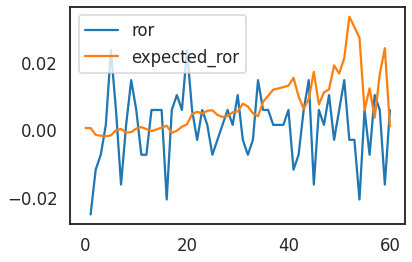

In [50]:
data[['ror','expected_ror']].plot()

In [51]:
data.corr()

,t,prices,buy,sell,ror,expected_ror,expected_std
t,1.000000,0.936456,-0.138082,-0.393214,0.025511,0.768430,0.805715
prices,0.936456,1.000000,-0.068181,-0.309051,-0.126247,0.856714,0.657454
buy,-0.138082,-0.068181,1.000000,0.699367,-0.258513,-0.031076,-0.097732
sell,-0.393214,-0.309051,0.699367,1.000000,-0.258527,-0.290486,-0.312833
ror,0.025511,-0.126247,-0.258513,-0.258527,1.000000,-0.217115,-0.039617
expected_ror,0.768430,0.856714,-0.031076,-0.290486,-0.217115,1.000000,0.508375
expected_std,0.805715,0.657454,-0.097732,-0.312833,-0.039617,0.508375,1.000000


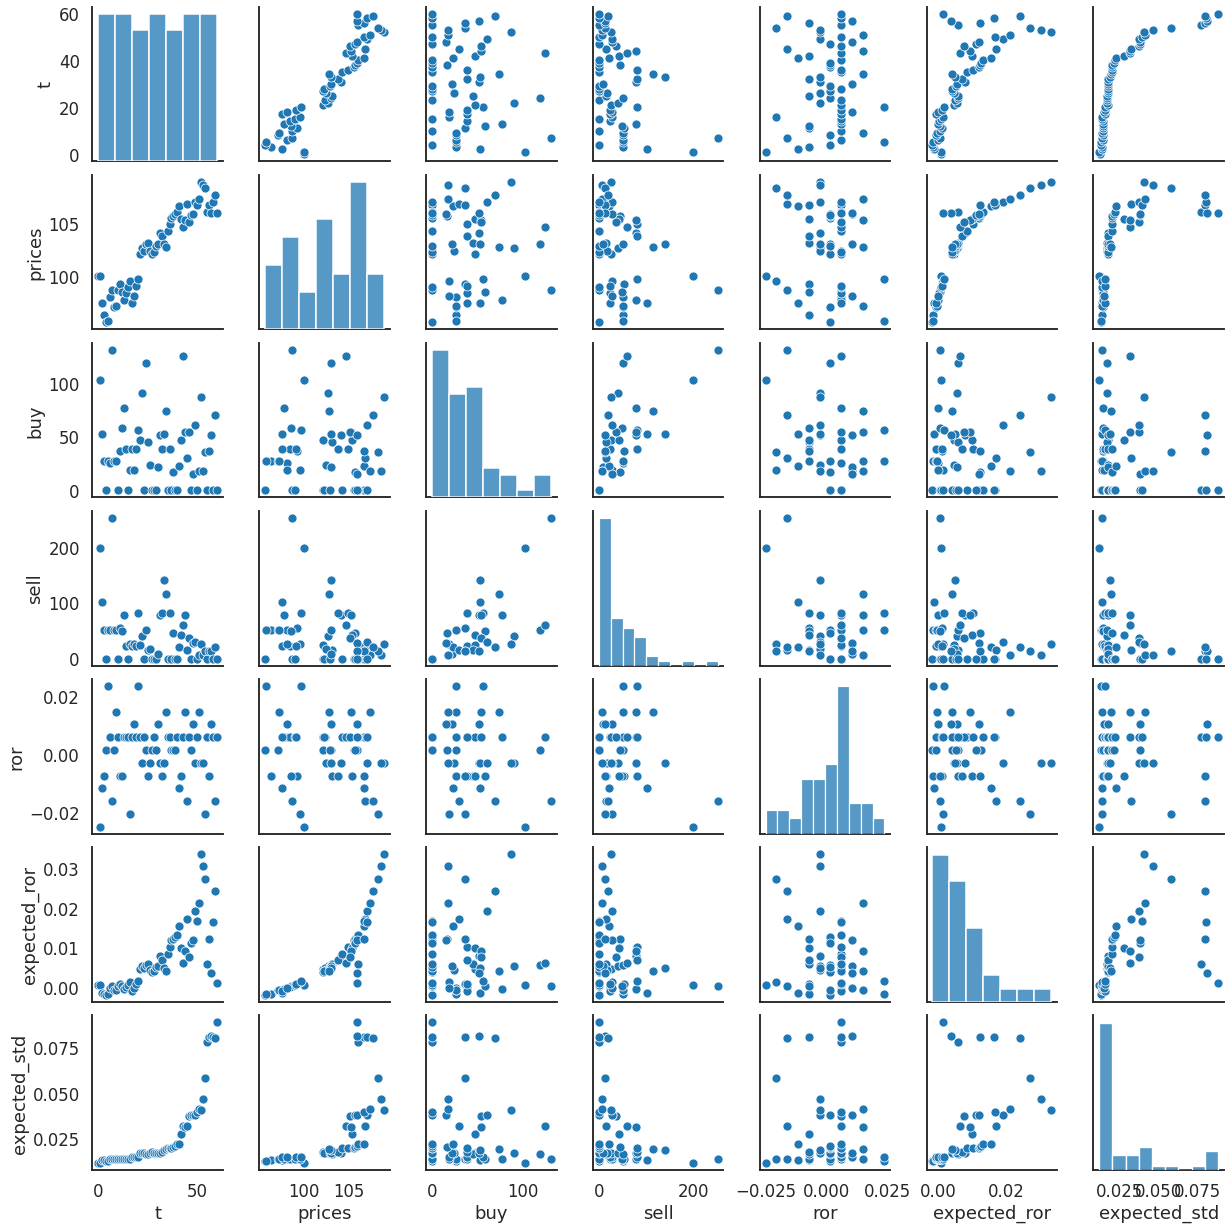

In [52]:
import seaborn as sns

sns.pairplot(data)